In [135]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy
import random

SEED = random.randint(1,100) 

Text(0, 0.5, 'X1')

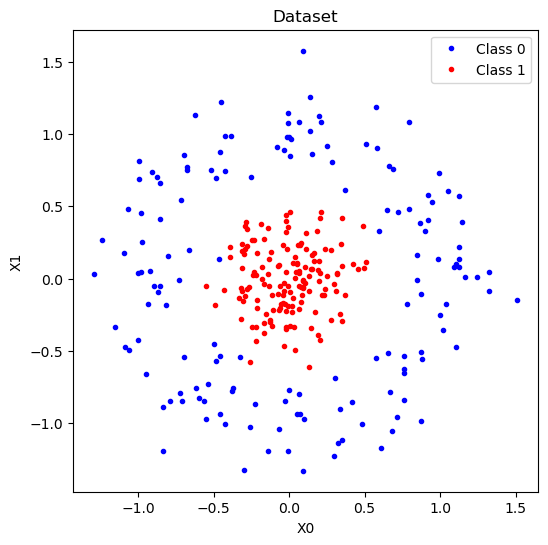

In [136]:
X,y = make_circles(n_samples=300, factor=0.1, noise=0.2,random_state=SEED)
n,s = X.shape
plt.figure(1,figsize=(6,6))
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b', label='Class 0')
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r', label='Class 1')
plt.title("Dataset")
plt.legend()
plt.xlabel("X0")
plt.ylabel("X1")

In [137]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

## Network Creation

In [138]:
class InputUnit:
    def __init__(self,data):
        self.data = data        #one column of matrix X
        self.n = data.shape[0]  #dataset size
        self.k = 0              #layer number
        self.z = 0              #unit output

    def plug(self, unit, where = 'following'):
        unit.plug(self, where = where)

    def forward(self,i):
        self.z = self.data[i]
        return self.z


In [139]:
class Loss:
    #Constructor
    def __init__(self,y,k):
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.y = y          #array of class labels of the training data
        self.k = k          #layer index
        self.l = 0
        self.delta = np.zeros((1,))

    def plug(self, unit, where = 'preceding'):
        unit.plug(self,where)

    def forward(self,i):
        if self.npr != 1:
            raise Exception("The Loss layer has more then one preceding")
        input = self.preceding[0].forward(i)
        if y[i] == 0:
            self.l = -np.log(1-input)
        else:
            self.l = -np.log(input)


        return self.l
    
    def backprop(self,i):
        if y[i] == 0:
            self.delta[0] = 1 / (1-self.preceding[0].z)
        else:
            self.delta[0] = - 1 / (self.preceding[0].z)

        
        return self.delta
        


In [140]:
class NeuralUnit:
    #Constructor
    def __init__(self,k,u,seed = SEED):
        self.u = u          #unit number
        self.preceding = [] #list of preceding neurons
        self.npr = 0        #length of list preceding
        self.following = [] #list of following neurons
        self.nfo = 0        #length of list following
        self.k = k          #layer number
        self.w = 0          #unit weights
        self.b = 0          #unit intercept
        self.z = 0          #unit output
        self.rng = np.random.default_rng(seed=seed)

    def __str__(self):
        return f"Unit {self.u} of layer {self.k}"

    def reset_params(self):
        self.w = self.rng.standard_normal(self.npr)
        self.b = self.rng.standard_normal()
        self.delta = np.zeros(self.w.shape)
        self.w_grad = np.zeros_like(self.w)
        self.b_grad = 0

    def plug(self,unit, where = 'preceding'):
        if isinstance(unit,NeuralUnit):
            if where == 'following':
                self.preceding.append(unit)
                unit.following.append(self)
                self.npr += 1
                unit.nfo += 1
                # print(f"{self} is after {unit}")
            elif where == 'preceding':
                self.following.append(unit)
                unit.preceding.append(self)
                self.nfo += 1
                unit.npr += 1
                # print(f"{self} is before {unit}")
        elif isinstance(unit,InputUnit):
            if where == 'following':
                raise Exception("Not possible to add neurone befor the input layer")
            elif where == 'preceding':
                self.preceding.append(unit)
                self.npr += 1
        elif isinstance(unit,Loss):
            if where == 'following':
                raise Exception("Not possible to add neurone after the Loss layer")
            elif where == 'preceding':
                self.following.append(unit)
                self.nfo += 1
                unit.preceding.append(self)
                unit.npr += 1

    def forward(self,i):
        input = np.zeros(self.npr)
        for j,unit in enumerate(self.preceding):
            input[j] = unit.forward(i)
        
        self.z = sigmoid(self.w.T@input + self.b)
        return self.z
    
    def backprop(self,i,deltas):
        
        for v,unit in enumerate(self.preceding):
            self.delta[v] = self.z * (1-self.z) * self.w[v] * deltas[self.u]


        for v,unit in enumerate(self.preceding):
            self.w_grad[v] = self.z * (1-self.z) * unit.z * deltas[self.u]

        self.b_grad = self.z * (1-self.z) * deltas[self.u]

        

In [141]:
class MLP:
    #Constructor
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) #number of layers (including input layer but omitting loss layer)
        #creating network

        net = []
        for layer_index in range(self.K):
            layer = []            
            for i in range(archi[layer_index]):
                if layer_index == 0:
                    input_unit = InputUnit(data=X[:,i])
                    layer.append(input_unit) #add InputUnit
                else:
                    neural_unit = NeuralUnit(layer_index,u=i)
                    for unit in net[layer_index-1]:
                        unit.plug(neural_unit,where='preceding')
                    neural_unit.reset_params()
                    layer.append(neural_unit)

            net.append(layer)

        layer = [] 
        loss_unit = Loss(y,self.K +1 )
        layer.append(loss_unit)
        for unit in net[-1]:
            loss_unit.plug(unit=unit)
            
        net.append(layer)

        self.net = net

    def forward(self,i):
        z = self.net[-1][0].forward(i)
        return z

    def backprop(self,i):
        self.net[self.K][0].backprop(i)
        deltas = self.net[self.K][0].delta
        for k in range(self.K-1,0,-1):
            deltas_new = np.zeros((self.net[k][0].npr,))
            for u in range(len(self.net[k])):
                self.net[k][u].backprop(i,deltas)
                deltas_new += self.net[k][u].delta
            deltas = deltas_new
    
    def update(self,eta):
        for layer in self.net:
            for unit in layer:
                if isinstance(unit,NeuralUnit):
                    unit.w = unit.w - eta * unit.w_grad
                    unit.b = unit.b - eta * unit.b_grad
    
    def train(self, epochs, eta):
        for epoch in range(epochs):
            loss_epoch = 0

            for i in range(self.n):
                loss_epoch += self.forward(i)
                self.backprop(i)
                self.update(eta)

            print("epoch", epoch, "loss", loss_epoch / self.n)
    
    def predict(self,i):
        z = self.net[-2][0].forward(i)
        return z

    def visualize(self):
        nb_params = 0
        for i, layer in enumerate(self.net):
            print(f"Layer{i}")
            s=''
            for j,unit in enumerate(layer):
                if i == 0:
                    s += f'|I| '
                elif i == len(self.net) -1:
                    s += '|O| '
                else :
                    s += f'|N{unit.u}| '
                    nb_params += len(unit.w) + 1
            print(s)
        print(f'Nomber of parameters : {nb_params}')
        



In [142]:
i = 0
archi = [2,10,1]
mlp = MLP(X,y,archi)
mlp.visualize()
mlp.forward(i)
mlp.backprop(i)
epsi=1e-3
mlp2 = copy.deepcopy(mlp)
mlp2.net[1][0].w[0] = mlp.net[1][0].w[0] + epsi
print("numerical derivative is :",(mlp2.forward(i) - mlp.forward(i))/epsi)
print("computed derivative is  :",mlp.net[1][0].w_grad[0])

Layer0
|I| |I| 
Layer1
|N0| |N1| |N2| |N3| |N4| |N5| |N6| |N7| |N8| |N9| 
Layer2
|N0| 
Layer3
|O| 
Nomber of parameters : 41
numerical derivative is : -0.0012342333444159692
computed derivative is  : -0.0012342189753735292


In [143]:
mlp.train(50,0.05)

epoch 0 loss 0.706196163847827
epoch 1 loss 0.5779891811937855
epoch 2 loss 0.517511175634854
epoch 3 loss 0.48391390390770994
epoch 4 loss 0.4619523454417026
epoch 5 loss 0.4457913736819355
epoch 6 loss 0.433356906843763
epoch 7 loss 0.42361551418594123
epoch 8 loss 0.4159049162918254
epoch 9 loss 0.40975109291288075
epoch 10 loss 0.40479790653557296
epoch 11 loss 0.40077011526151335
epoch 12 loss 0.3974497819293313
epoch 13 loss 0.39465922303772244
epoch 14 loss 0.3922472730596615
epoch 15 loss 0.3900767981810852
epoch 16 loss 0.3880116555901188
epoch 17 loss 0.3859011181842904
epoch 18 loss 0.3835594398888259
epoch 19 loss 0.38073824521526245
epoch 20 loss 0.37709106539892345
epoch 21 loss 0.3721350116349609
epoch 22 loss 0.3652268170061161
epoch 23 loss 0.35558854061429024
epoch 24 loss 0.3424357274757502
epoch 25 loss 0.32526472528401984
epoch 26 loss 0.30428479932525243
epoch 27 loss 0.2807058709594703
epoch 28 loss 0.25639756235826455
epoch 29 loss 0.23305293093309387
epoch 30 l

In [144]:
print(y[:3])
print(mlp.predict(0),mlp.predict(1),mlp.predict(2))

[0 0 1]
0.15047074944265457 0.09284437436937454 0.7311108420913657


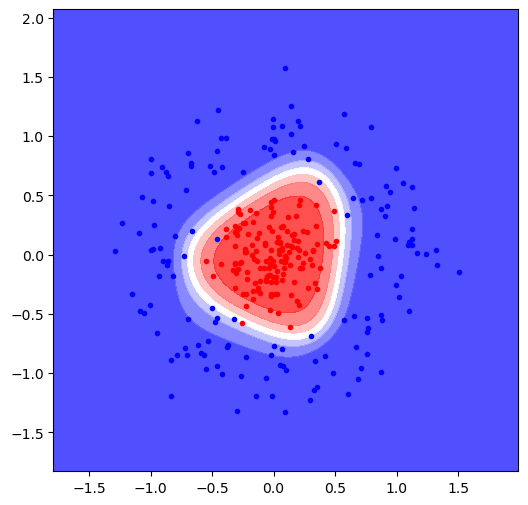

In [145]:
h = .02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z = []
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp.predict(i))
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X[:,u]
Z = np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(2,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)